In [17]:
!ls

fashion-mnist_test.csv  fashion.ipynb           t10k-labels-idx1-ubyte
fashion-mnist_train.csv t10k-images-idx3-ubyte


In [45]:
#IMPORTS
import pandas as pd
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [35]:
#LOAD CSV DATA
#tr_filename = 'fashion-mnist_train.csv'
#tr = pd.read_csv(tr_filename)

In [36]:
#LOAD IMAGE DATA
f = 'train-images-idx3-ubyte'
l = 'train-labels-idx1-ubyte'
imagearray = idx2numpy.convert_from_file(f)
labels = idx2numpy.convert_from_file(l)

tf = 't10k-images-idx3-ubyte'
tl = 't10k-labels-idx1-ubyte'
test_imagearray = idx2numpy.convert_from_file(tf)
test_labels = idx2numpy.convert_from_file(tl)

(60000, 28, 28)


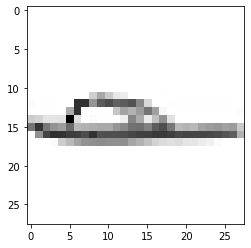

In [37]:
plt.imshow(imagearray[30], cmap=plt.cm.binary)
print(imagearray.shape)
#print(label_map[labels[30]])
#print(imagearray[30])

In [38]:
#Preprocessing, normalize data
class Normalize:
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit(self, X):
        self.mean = np.mean(X)
        self.std = np.std(X)
        
    def normalize(self, X):
        X -= self.mean
        X /= self.std
        return X

In [40]:
imgs = imagearray.copy()
lbls = labels.copy()
test_imgs = test_imagearray.copy()
test_lbls = test_labels.copy()

imgs.flags.writeable = True
imgs = imgs.astype(np.float64)
test_imgs.flags.writeable = True
test_imgs = test_imgs.astype(np.float64)

scale = Normalize()
scale.fit(imgs)

imgs = scale.normalize(imgs)
test_imgs = scale.normalize(test_imgs)


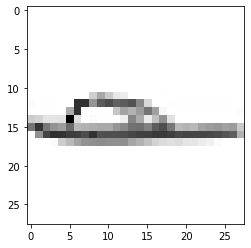

In [41]:
plt.imshow(imgs[30], cmap=plt.cm.binary)

In [30]:
#Split training data into training and validation sets
def train_val_split(X, y, percent=85):
    percent = float(percent)
    if(percent > 1): 
        percent = percent/100
    assert X.shape[0] == y.shape[0]
    idxs = np.random.permutation(y.shape[0])
    i = int(percent*y.shape[0])
    train_X, train_y = X[0: i], y[0: i]
    val_X, val_y = X[i:], y[i:]
    return train_X, train_y, val_X, val_y

In [31]:
train_X, train_y, val_X, val_y = train_val_split(imgs, lbls)

In [43]:
#Store all hyperparameters here
hyperparams = {
    'batch_size': 50,
    'learning_rate': 1e-4,
    'num_epochs': 50,
}

In [44]:
#Define data loaders to cooperate with torch training loop
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_X), torch.from_numpy(val_y))
tr_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hyperparams['batch_size'], shuffle=False)

#Do we need to define a Dataset & DataLoader for the test dataset?
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_imgs), torch.from_numpy(test_lbls))
test_loader = torch.utils.data.DataLoader(test_dataset)

In [49]:
#Define CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 5, 5, 2)
        self.conv2 = nn.Conv2d(5, 50, 5, 2)
        
        self.fc1 = nn.Linear(1250, 100)
        self.fc1 = nn.Linear(100, 32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        
        #Conv layer 1
        x = F.relu(self.conv1(x))
        
        #Conv layer 2
        x = F.relu(self.conv2(x))
        
        #Flatten
        x = x.view(-1, 1250)
        
        #Fully connected 1
        x = F.relu(self.fc1(x))
        
        #Fully connected 2
        x = F.relu(self.fc2(x))
        
        #Fully connected 3, (does not apply softmax... yet)
        x = self.fc3(x)
        
        return x

#Apply softmax to get predicted label
def predict(network_output):
    
    assert network_output.shape[1] == 10
    
    pred = F.softmax(network_output, 1)
    
    return torch.argmax(pred, dim=1)

#Load and save model funcs from state_dict
def save(model, path):
    torch.save(model.state_dict(), path)
    
def load(path, eval_mode = False):
    model = CNN()
    model.load_state_dict(torch.load(path))
    if eval_mode:
        model.eval()   
    return model
    

In [ ]:
#training loop
model = CNN()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])

train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(hyperparam['num_epochs']):
    
    #Evaluate training batch
    for i, X, y in enumerate(tr_loader):
        
        #Zero out gradients
        optim.zero_grad()
        
        
        #Forward pass of training batch
        output = model(X)
        
        #Compute loss of batch
        loss = criterion(output, y)
        
        #Calculate gradients (backprop)
        loss.backward()
        
        #Update parameters (ADAM)
        optimizer.step()
    
   
    
    
    #Evaluate training AND validation accuracy && loss
    y_true, y_pred = [], []
    correct, total = 0.0, 0.0
    running_loss = []
    
    for X, y in tr_loader:
        with torch.no_grad():
            output = Model(X)
            preds = predict(output)
            
            y_true.append(y)
            y_pred.append(preds)
            
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
            running_loss.append(criterion(output, y).item())
    
    train_loss.append(np.mean(running_loss))
    train_acc.append(correct/total)
    
    y_true, y_pred = [], []
    correct, total = 0.0, 0.0
    running_loss = []
    for X, y in val_loader:
        with torch.no_grad():
            output = Model(X)
            preds = predict(output)
            
            y_true.append(y)
            y_pred.append(preds)
            
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
            running_loss.append(criterion(output, y).item())
    
    val_loss.append(np.mean(running_loss))
    val_acc.append(correct/total)
    
    #Save model
    save(model, f'eo')